In [1]:
# pandas and plotting libraries for visualizations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# module containing functions for manipulating pyspark dataframes
import pyspark.sql.functions as f

# class which will let us create spark objects
from pyspark.sql import SparkSession

# helper functions for intro class
from helpers import display, read_df

## [PySpark SQL docs](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html)
 - the main functions you'll need to manipulate data in pyspark dataframes are in this module

## [Data Dictionary](https://digital.cityofchicago.org/index.php/chicago-taxi-data-released/)
 - details about the dataset used, here filtered down to just 2016 data

## Create a Spark Session

In [2]:
spark = (
    SparkSession
    .builder
    .appName('data_exploration')
    .master('local[2]')
    .getOrCreate()
)

## Read in data file

In [3]:
df = read_df(spark, '../taxi_2016')

In [4]:
display(df)

,trip_id,taxi_id,start_time,end_time,trip_miles,pickup_census_tract,dropoff_census_tract,fare,tips,trip_total,payment_type,company
0,2d4585c3a01188a7032e7bea0f2ac686a869832c,fe33d0d63aa20b97b9d4440ad1b6637ea21a0df546aa0d...,2016-12-17 23:30:00,2016-12-17 23:30:00,0.8,1.703128e+10,1.703183e+10,5.50,1.00,7.00,Credit Card,None
1,2d458675ac892b200cb039fbbe845e2e90c1131c,c12e0923159de80ee3288c44047308ab8f602fbfb2278f...,2016-02-20 02:30:00,2016-02-20 02:30:00,2.6,1.703108e+10,1.703124e+10,9.75,2.15,12.90,Credit Card,Choice Taxi Association
2,2d4587774ae4ef68c78e7f328c6b0a12873a50db,0083fcde0fb490b4ec424c63d1d750378f6ad11154d1d4...,2016-02-11 07:15:00,2016-02-11 07:45:00,0.8,NaN,NaN,39.50,0.00,39.50,Cash,Taxi Affiliation Services
3,2d458989ecc7bd5aa9f8657c4bbe430347ab5189,874b25eb25690a1a0361023234f59edeee52101733a1ab...,2016-08-17 18:45:00,2016-08-17 19:00:00,1.8,1.703108e+10,1.703183e+10,10.25,2.00,12.75,Credit Card,None
4,2d458a76dea4503ee43e5f6f41166a219eacb7ce,45772661016b0b77e44155eaf32f92d2f4e9e2702c0fc3...,2016-07-15 00:15:00,2016-07-15 00:30:00,5.1,NaN,NaN,16.50,3.00,21.00,Credit Card,Dispatch Taxi Affiliation


In [5]:
df.columns

['trip_id',
 'taxi_id',
 'start_time',
 'end_time',
 'trip_miles',
 'pickup_census_tract',
 'dropoff_census_tract',
 'fare',
 'tips',
 'trip_total',
 'payment_type',
 'company']

In [6]:
total_rows = df.count()
print(total_rows)

2996733


let's take a smaller sample so we can iterate faster

In [7]:
df = df.sample(fraction=.1)

In [8]:
df.count()

299607

### there are 3 main forms that data manipulations take:
 * some are dataframe methods (like `agg` or `count`)
 * some are functions that take a column or column name as input (like `countDistinct`)
 * some are column methods (like `alias`)


In [9]:
display(df.agg(f.countDistinct('taxi_id').alias('num_taxis')))

,num_taxis
0,4651


In [10]:
# df.countDistinct('taxi_id') # NOT CORRECT SYNTAX

In [11]:
# df.select(f.distinct(f.col('taxi_id'))) # NOT CORRECT SYNTAX

In [12]:
df.select('taxi_id').distinct().count()

4651

### multiple aggregations

✅ `df.agg(agg1, agg1)`

❌ `df.agg([agg1, agg1])`

✅ `df.agg(*[agg1, agg1])`

In [13]:
total_rows = df.count()

find percent non-null in each column:

In [14]:
display(
    df.agg(
        *[(f.count(c)/total_rows).alias(c) for c in df.columns]
    )
)

,trip_id,taxi_id,start_time,end_time,trip_miles,pickup_census_tract,dropoff_census_tract,fare,tips,trip_total,payment_type,company
0,1.0,1.0,1.0,0.99989,1.0,0.707457,0.704646,1.0,1.0,1.0,1.0,0.635286


### Visualizations

In [15]:
trips_per_taxi = df.groupBy('taxi_id').count()

In [16]:
display(trips_per_taxi, 10)

,taxi_id,count
0,5339c272e8a85babf1e53c2ab4689a3225f1d8128d7c60...,94
1,a3715bdf7bbe4780c74ae3ef616fb1b7e0cff450b2c93a...,50
2,3ce16d151260438f64e60dbfdb5c395172745e87eb4032...,138
3,bb7eb49d01457ba3d389fa22e21f51c681a38b1032e6b2...,79
4,1e4ba7f6a2c79ac2220073aa7006dd757feed6b12d4a40...,94
5,7da8dfbf5db7bed94dd92856d29697c070590f703b0b29...,49
6,2da10ef251c77931d8faab56db31e4da1a420c077b8561...,71
7,da1fa60939f1104bf62e3da8810c71674cc212235ae04c...,68
8,0e21caaf401f961b7ae5a4c3d8c5b70291ccc2b6c2138c...,168
9,cce26db27b3d8d566473e326d450541ea93cbcec5ed6d4...,144


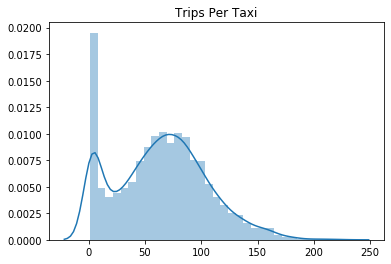

In [17]:
plt.figure()
sns.distplot(trips_per_taxi.select('count').toPandas()).set_title('Trips Per Taxi');

In [18]:
distance_traveled_per_taxi = (
    df
    .groupBy('taxi_id')
    .agg(f.sum('trip_miles').alias('miles'), f.max('trip_miles').alias('max_miles'))
)

In [19]:
display(distance_traveled_per_taxi, 10)

,taxi_id,miles,max_miles
0,5339c272e8a85babf1e53c2ab4689a3225f1d8128d7c60...,376.0,24.2
1,a3715bdf7bbe4780c74ae3ef616fb1b7e0cff450b2c93a...,236.9,21.0
2,3ce16d151260438f64e60dbfdb5c395172745e87eb4032...,342.7,18.7
3,bb7eb49d01457ba3d389fa22e21f51c681a38b1032e6b2...,267.3,17.8
4,1e4ba7f6a2c79ac2220073aa7006dd757feed6b12d4a40...,265.2,18.0
5,7da8dfbf5db7bed94dd92856d29697c070590f703b0b29...,239.5,17.9
6,2da10ef251c77931d8faab56db31e4da1a420c077b8561...,228.2,21.7
7,da1fa60939f1104bf62e3da8810c71674cc212235ae04c...,275.3,22.2
8,0e21caaf401f961b7ae5a4c3d8c5b70291ccc2b6c2138c...,26.8,1.6
9,cce26db27b3d8d566473e326d450541ea93cbcec5ed6d4...,474.9,29.5


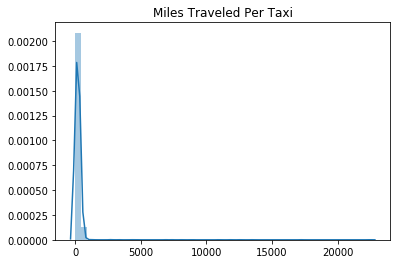

In [20]:
plt.figure()
(
    sns
    .distplot(distance_traveled_per_taxi.select('miles').toPandas())
    .set_title('Miles Traveled Per Taxi')
);

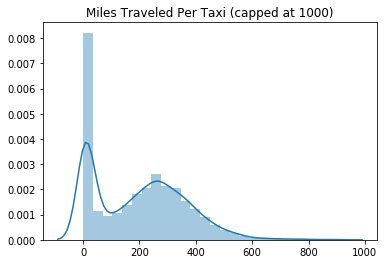

In [21]:
plt.figure()
(
    sns
    .distplot(distance_traveled_per_taxi.where('miles < 1000').select('miles').toPandas())
    .set_title('Miles Traveled Per Taxi (capped at 1000)')
);

In [22]:
display(distance_traveled_per_taxi.orderBy('miles', ascending=False), 10)

,taxi_id,miles,max_miles
0,435c3f0bb3774c35800330140eb6a9027c7f72033f0a60...,22488.2,1790.0
1,3ae312cce1e5d2337872c81e8f1e7873a88de4d26fd7ae...,17252.8,1970.0
2,770c8eeffb35f5fb925ceecfac5201171e3ecdaf5bacaa...,13535.9,1840.0
3,11cec1092eb4f4b50433778d436f251983dd37d567f709...,12598.0,1780.0
4,26d55de9d7e34ab98da76d4c1c5e7d5c5507bc02dcdbb4...,11883.3,2480.0
5,6c102217d9b79e673a7f41e646aaa9c519dff7d3850f86...,10988.9,1780.0
6,0ee86e2a204cc2224e9ff2494686ee474cce6aba093a1b...,8915.5,1830.0
7,3a27defb5d45f78ffccdc4b08f679a5d75f4bdebf9f9c0...,8166.4,1800.0
8,17115662c9dd034ea6956fc43b9be4653b7ada5ee06582...,7398.3,1730.0
9,93d7461f270fbd0bf1d961575942b018e48b4098378028...,6911.1,1690.0


### Alternate filering syntax:
`distance_traveled_per_taxi.where(f.col('miles') < 1000)`

`distance_traveled_per_taxi.filter(f.col('miles') < 1000)`

`distance_traveled_per_taxi.where('miles < 1000')`

`distance_traveled_per_taxi.filter('miles < 1000')`

## Exercises

### when do most trips occur? 

In [23]:
display(
    df
    .groupby(f.hour('start_time'))
    .count()
    .orderBy(f.desc('count')),
    10
)

# Looks like early evening is most popular, with most trips starting between 5-7pm

,hour(start_time),count
0,19,20327
1,18,20229
2,17,18679
3,20,17989
4,16,17290
5,13,15766
6,14,15689
7,15,15624
8,12,15529
9,21,15376


### what's the most common length for a trip in miles? in minutes?

In [24]:
display(df.groupBy('trip_miles').count().orderBy(f.desc('count')), 10)

# Looks like most trips are under a mile, with the highest number being listed at 0 miles 
# (remember these distances are rounded)

,trip_miles,count
0,0.0,58644
1,0.1,10971
2,1.0,10361
3,0.9,9870
4,0.8,9861
5,1.1,9798
6,0.7,9418
7,1.2,8102
8,0.6,8025
9,1.3,7297


In [25]:
trip_length_minutes = (
    df
    .withColumn(
        'minutes',
        (f.unix_timestamp(f.col('end_time')) - f.unix_timestamp(f.col('start_time')))/60
    )
    .groupBy('minutes')
    .count()
)

display(trip_length_minutes.orderBy('count', ascending=False), 10)

# The vast majority are under an hour, with most being around 15 minutes (this data is rounded to the nearest 15)

,minutes,count
0,15.0,144230
1,0.0,107159
2,30.0,31370
3,45.0,11040
4,60.0,3927
5,75.0,1187
6,90.0,323
7,105.0,105
8,120.0,52
9,NaN,33


### are there companies that only use cash or only use credit?

In [26]:
cash = (
    df
    .where('payment_type == "Cash"')
    .where('company is not null')
    .select('company')
    .distinct()
)
credit = (
    df
    .where('payment_type == "Credit Card"')
    .where('company is not null')
    .select('company')
    .distinct()
)

print('{} companies use cash, {} companies use credit'.format(cash.count(), credit.count()))


54 companies use cash, 52 companies use credit


In [27]:
display(cash.join(credit, on='company', how='left_anti')) # select rows in cash that are not in credit

,company
0,4732 - Maude Lamy
1,Chicago Elite Cab Corp. (Chicago Carriag
2,2092 - 61288 Sbeih company


In [28]:
display(credit.join(cash, on='company', how='left_anti')) # select rows in credit that are not in cash

,company
0,Suburban Dispatch LLC


In [29]:
spark.stop()